In [1]:
import warnings
from typing import Callable, List, Optional, Sequence, Tuple, Union

import torch
import torchvision
from torch import Tensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.autograd as autograd
import math
from scipy.stats import ortho_group
from math import sin
from scipy.stats import special_ortho_group

In [2]:
# define new layer inheriting nn.Module
class NormalizedLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None:
        super().__init__(in_features, out_features, bias, device, dtype)

    def forward(self, input: Tensor) -> Tensor:
        x = super().forward(input)
        x *= (1 / (x.size(1) ** 0.5))
        return x   

In [3]:
class MLP(torch.nn.Module):

    def __init__(
        self,
        in_channels: int,
        hidden_channels: List[int],
        norm_layer: Optional[Callable[..., torch.nn.Module]] = None,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        inplace: Optional[bool] = None,
        bias: bool = True,
        dropout: float = 0.0,
        gamma: float = 1.0,
    ):
        super(MLP, self).__init__()
        params = {} if inplace is None else {"inplace": inplace}
        self.gamma = 1 # math.sqrt(in_channels)

        layers = []
        in_dim = in_channels
        for hidden_dim in hidden_channels[:-1]:
            layers.append(NormalizedLinear(in_dim, hidden_dim, bias=bias))

            if norm_layer is not None:
                layers.append(norm_layer(hidden_dim))
            layers.append(activation_layer())
            #layers.append(torch.nn.Dropout(dropout, **params))
            in_dim = hidden_dim

        layers.append(torch.nn.Linear(hidden_channels[-2], hidden_channels[-1], bias=bias))
        #layers.append(torch.nn.Dropout(dropout, **params))

        # self.model = nn.Sequential(*layers)
        self.layers = nn.Sequential(*layers)

    def init_weights(self) -> None:
         for layer in self.layers:
             if isinstance(layer, torch.nn.Linear):
                #make the initialization of weights from a normal distribution
                torch.nn.init.xavier_normal_(layer.weight.data)
                #torch.nn.init.kaiming_normal_(layer.weight.data)
                # multiply by 100
                #layer.weight.data *= 10.0
                if layer.bias is not None:
                    torch.nn.init.zeros_(layer.bias.data)

    #Alternative definition of forward
    def forward(self, x):
        x = self.layers.forward(x)
        x = (1 / self.gamma) * x
        return x   

    # create a forward functions that stops before the last layer is applied
    def forward_partial(self, x):
        #forward but stop before the last layer is applied
        for layer in self.layers[:-1]:
            x = layer(x)
        return x

    def forward_partial2(self, x):
        for layer in self.layers[:-3]:
            x = layer(x)
        return x

    def forward_partial3(self, x):
        for layer in self.layers[:-5]:
            x = layer(x)
        return x


In [4]:
def train(x, y, x_test, y_test, model, lr=1e-2, epochs = 10, batch_size = 2**9):
    assert x.shape[0] == y.shape[0]
    assert y.shape[0] % batch_size == 0
    
    #model = MLP(x.shape[1], [256, 128, 1])
    #model.init_weights()
    loss_fn = torch.nn.MSELoss()

    x_batched = x.reshape(-1, batch_size, x.shape[1])
    y_batched = y.reshape(-1, batch_size, y.shape[1])

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    test_loss_history = []
    
    for epoch in range(epochs):
        for i in range(x_batched.shape[0]):
            optimizer.zero_grad()

            y_pred = model.forward(x_batched[i])

            loss = loss_fn(y_pred, y_batched[i])
            loss_history.append(loss.item())

            loss.backward()
            optimizer.step()

            # get test pred and loss
            with torch.no_grad():
                test_pred = model.forward(x_test)

                test_loss = loss_fn(test_pred, y_test)
                test_loss_history.append(test_loss.item())


        print(f"epoch {epoch}, loss: ", loss.item())
        print(f"epoch {epoch}, test loss: ", test_loss.item())

    final_test_pred = model.forward(x_test)
    return loss_history, test_loss_history, final_test_pred

def test(x, y, model):
    y_pred = model.forward(x)
    accuracy = (y_pred == y).sum().item() / len(y)
    return accuracy

In [10]:
train_size = 2**13
test_size = 2**9

dim_size = 9
torch.manual_seed(44)
x = torch.randn(train_size + test_size, dim_size) / torch.sqrt(torch.tensor(dim_size).float())

x_train = x[:train_size]
x_test = x[train_size:]


# generate random hyperplane
w = torch.randn(dim_size, 1) / torch.sqrt(torch.tensor(dim_size).float())

# noise value (TODO: experiment with this)
eta = 1e-2

y = torch.sin(2 * (x @ w))
y  = y + torch.randn(train_size + test_size, 1) * eta
y_train = y[:train_size]
y_test = y[train_size:]
# print(x_train)
# print(y_train)

In [ ]:
model = MLP(dim_size, [1024, 512, 256, 128, 1])
model.init_weights()

In [11]:
# define a gram matrix function to compute the gram matrix using the forward_partial function
def gram_matrix(x, model):
    # get the output of the model before the last layer
    x1 = model.forward_partial(x)
    x2 = model.forward_partial2(x)
    x3 = model.forward_partial3(x)
    # compute the gram matrix
    print(x.shape)
    gram1 = (1 / x1.shape[1]) * torch.matmul(x1, x1.T)
    gram2 = (1 / x2.shape[1]) * torch.matmul(x2, x2.T)
    gram3 = (1 / x3.shape[1]) * torch.matmul(x3, x3.T)
    return gram1, gram2, gram3

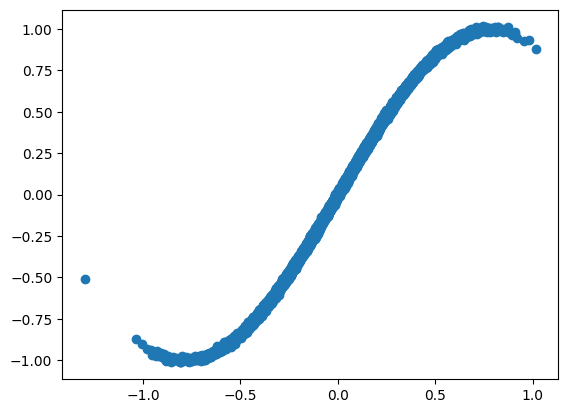

In [12]:
plt.scatter(x_train @ w, y_train)

torch.Size([512, 9])


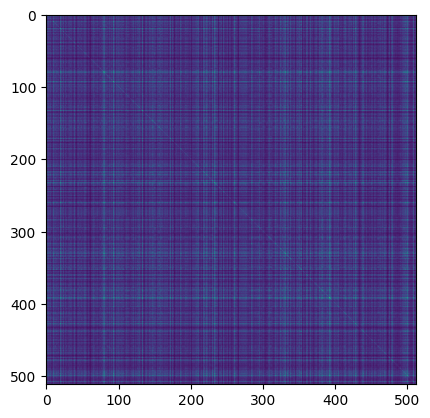

In [13]:
gram1, gram2, gram3 = gram_matrix(x_test, model)

# plot gram matrix before training
plt.imshow(gram1.detach().numpy())

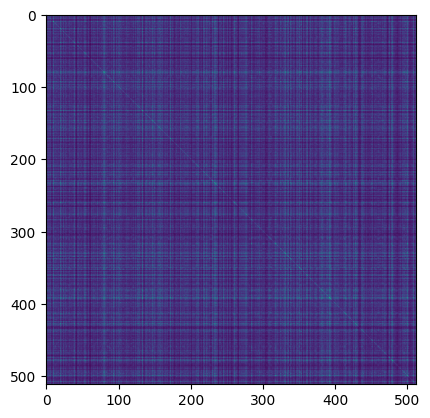

In [14]:
plt.imshow(gram2.detach().numpy())

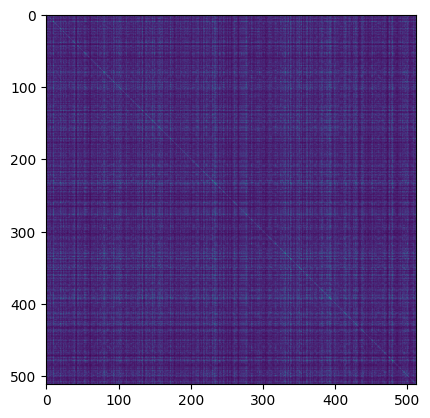

In [15]:
plt.imshow(gram3.detach().numpy())

In [16]:
loss_history, test_loss_history, final_test_pred = train(x_train, y_train, x_test, y_test, model, lr=1e-4, epochs=1000)

epoch 0, loss:  0.2711009681224823
epoch 0, test loss:  0.25288859009742737
epoch 1, loss:  0.2710949182510376
epoch 1, test loss:  0.25287020206451416
epoch 2, loss:  0.27108967304229736
epoch 2, test loss:  0.25285324454307556
epoch 3, loss:  0.27108484506607056
epoch 3, test loss:  0.25283777713775635
epoch 4, loss:  0.2710801959037781
epoch 4, test loss:  0.252823144197464
epoch 5, loss:  0.27107518911361694
epoch 5, test loss:  0.2528091073036194
epoch 6, loss:  0.271068811416626
epoch 6, test loss:  0.25279462337493896
epoch 7, loss:  0.2710597813129425
epoch 7, test loss:  0.2527783513069153
epoch 8, loss:  0.2710444927215576
epoch 8, test loss:  0.2527567148208618
epoch 9, loss:  0.2710159718990326
epoch 9, test loss:  0.2527228891849518
epoch 10, loss:  0.27096328139305115
epoch 10, test loss:  0.2526661157608032
epoch 11, loss:  0.2708667814731598
epoch 11, test loss:  0.2525672912597656
epoch 12, loss:  0.27068787813186646
epoch 12, test loss:  0.252388596534729
epoch 13, lo

torch.Size([512, 9])
tensor([[0.0022, 0.0008, 0.0015,  ..., 0.0009, 0.0011, 0.0024],
        [0.0008, 0.0019, 0.0013,  ..., 0.0018, 0.0016, 0.0007],
        [0.0015, 0.0013, 0.0014,  ..., 0.0013, 0.0013, 0.0016],
        ...,
        [0.0009, 0.0018, 0.0013,  ..., 0.0017, 0.0016, 0.0008],
        [0.0011, 0.0016, 0.0013,  ..., 0.0016, 0.0015, 0.0011],
        [0.0024, 0.0007, 0.0016,  ..., 0.0008, 0.0011, 0.0027]],
       grad_fn=<MulBackward0>)


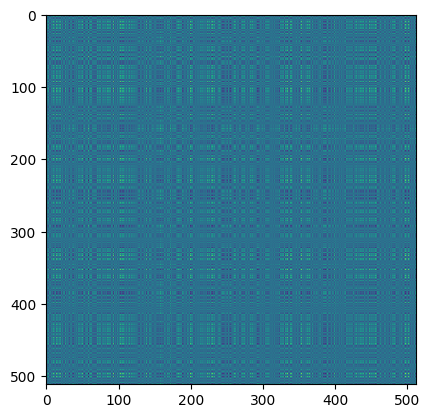

In [18]:
# calculate gram matrix for after training
gram_after1, gram_after2, gram_after3 = gram_matrix(x_test, model)
print(gram_after1)

# plot gram matrix
plt.imshow(gram_after1.detach().numpy())

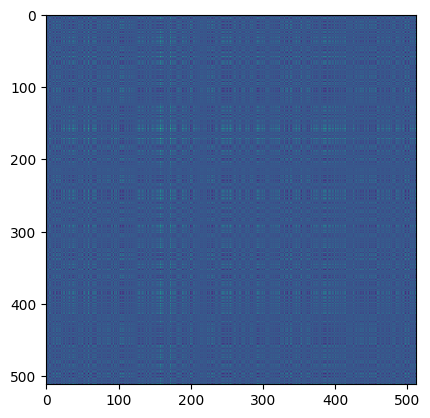

In [19]:
plt.imshow(gram_after2.detach().numpy())

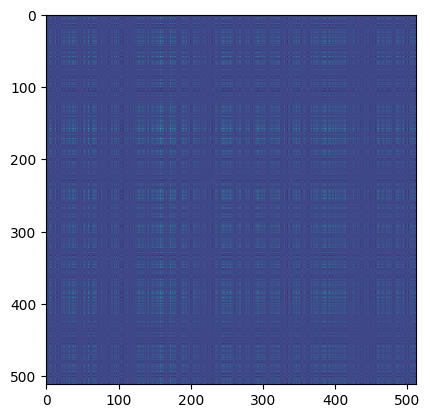

In [20]:
plt.imshow(gram_after3.detach().numpy())

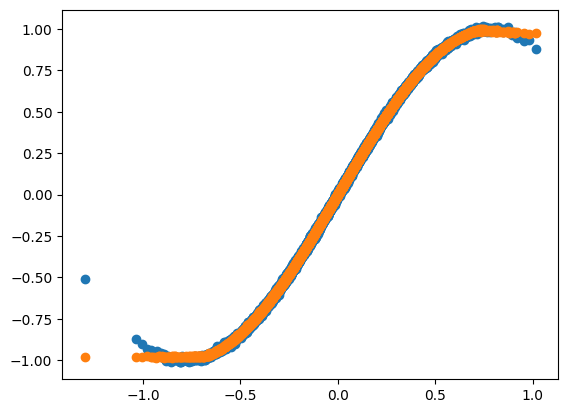

In [21]:
plt.plot(x_train @ w, y_train, 'o')
plt.plot(x_train @ w, model.forward(x_train).detach(), 'o')

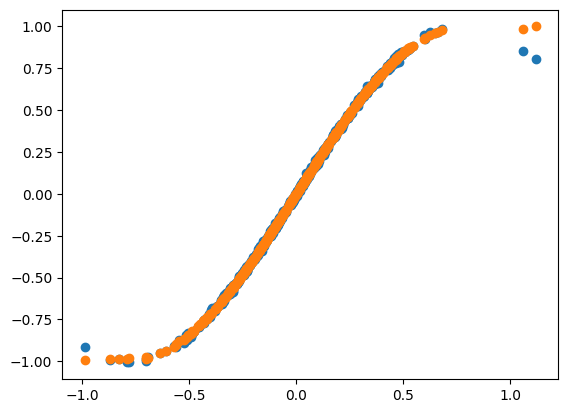

In [22]:
plt.plot(x_test @ w, y_test, 'o')
plt.plot(x_test @ w, model.forward(x_test).detach(), 'o')

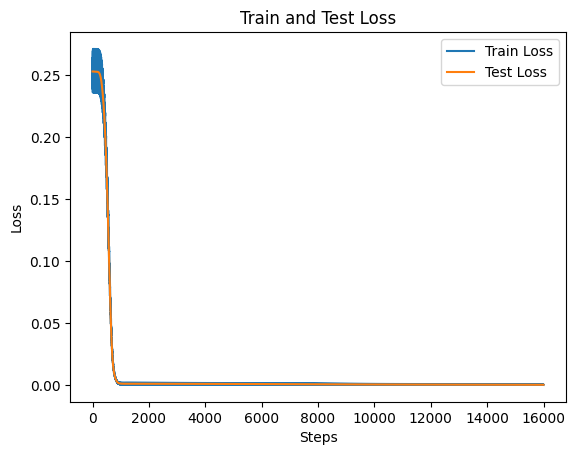

In [23]:
plt.plot(loss_history)
plt.plot(test_loss_history)
plt.title("Train and Test Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.show()

In [29]:
# rotate x but keep dimensions
x = x @ ortho_group.rvs(dim_size)
x = x.float()
print(x.size())
print(x)

x_train = x[:train_size]
x_test = x[train_size:]

model2 = MLP(dim_size, [1024, 512, 256, 128, 1])
model2.init_weights()

torch.Size([8704, 9])
tensor([[ 0.4982,  0.3147, -0.5821,  ...,  0.0674, -0.2080,  0.1128],
        [-0.2073, -0.3183,  0.5367,  ..., -0.1627, -0.3587, -0.1517],
        [ 0.9174,  0.0337,  0.1398,  ...,  0.2142,  0.1207, -0.2415],
        ...,
        [ 0.1993, -0.1423,  0.1734,  ..., -0.0462,  0.2005,  0.3393],
        [ 0.3902,  0.5648,  0.0828,  ..., -0.5310, -0.0220,  0.1385],
        [-0.4096, -0.1728,  0.2178,  ..., -0.0987,  0.3563, -0.4346]])


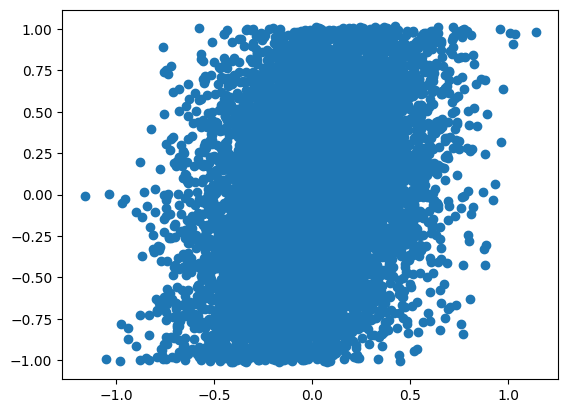

In [30]:
plt.scatter(x_train @ w, y_train)

torch.Size([512, 9])


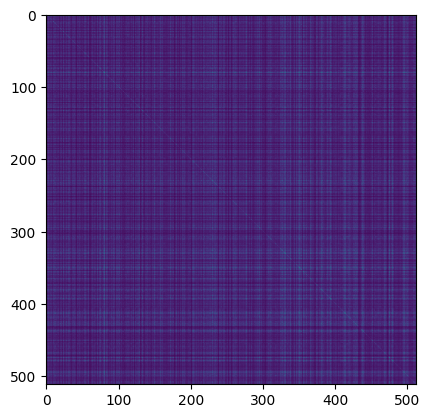

In [31]:
gram1, gram2, gram3 = gram_matrix(x_test, model2)

plt.imshow(gram1.detach().numpy())

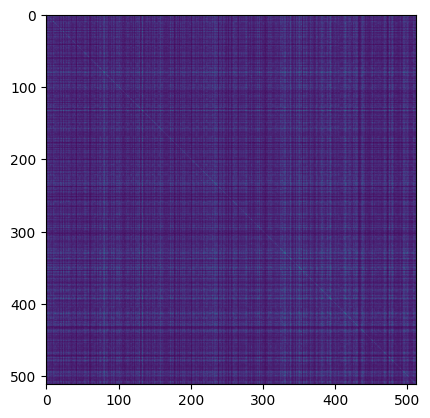

In [32]:
plt.imshow(gram2.detach().numpy())

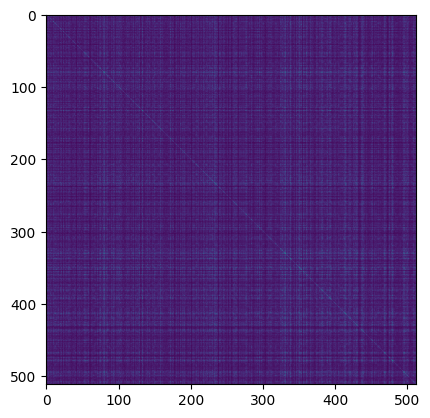

In [34]:
plt.imshow(gram3.detach().numpy())

In [35]:
loss_history, test_loss_history, final_test_pred = train(x_train, y_train, x_test, y_test, model2, lr=1e-4, epochs=1000)

epoch 0, loss:  0.27110183238983154
epoch 0, test loss:  0.2528911828994751
epoch 1, loss:  0.2710968255996704
epoch 1, test loss:  0.25287532806396484
epoch 2, loss:  0.2710922360420227
epoch 2, test loss:  0.2528601288795471
epoch 3, loss:  0.27108824253082275
epoch 3, test loss:  0.2528463900089264
epoch 4, loss:  0.27108463644981384
epoch 4, test loss:  0.25283345580101013
epoch 5, loss:  0.27108123898506165
epoch 5, test loss:  0.25282150506973267
epoch 6, loss:  0.2710780203342438
epoch 6, test loss:  0.25281059741973877
epoch 7, loss:  0.2710743248462677
epoch 7, test loss:  0.25279948115348816
epoch 8, loss:  0.27106985449790955
epoch 8, test loss:  0.25278863310813904
epoch 9, loss:  0.27106350660324097
epoch 9, test loss:  0.2527763247489929
epoch 10, loss:  0.27105385065078735
epoch 10, test loss:  0.2527613639831543
epoch 11, loss:  0.2710360288619995
epoch 11, test loss:  0.25273948907852173
epoch 12, loss:  0.2710065543651581
epoch 12, test loss:  0.25270670652389526
epoc

torch.Size([512, 9])


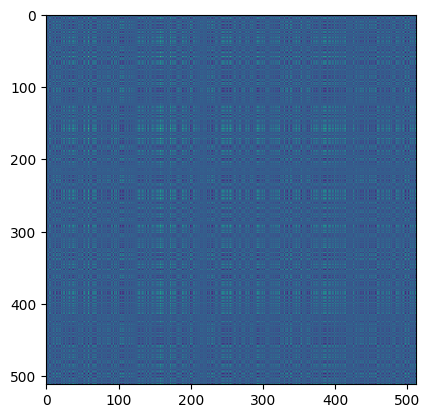

In [36]:
gram_after1, gram_after2, gram_after3 = gram_matrix(x_test, model2)

plt.imshow(gram_after1.detach().numpy())

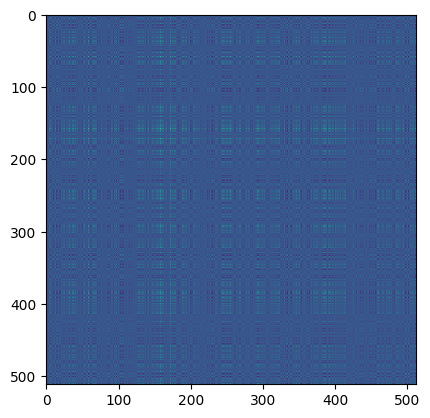

In [37]:
plt.imshow(gram_after2.detach().numpy())

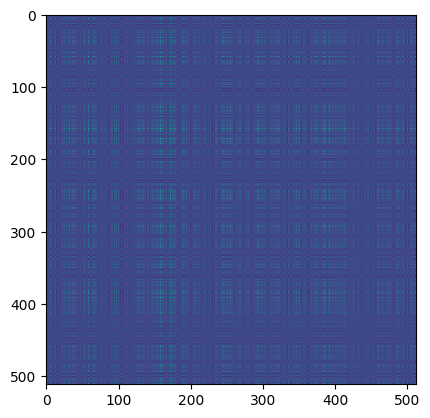

In [38]:
plt.imshow(gram_after3.detach().numpy())

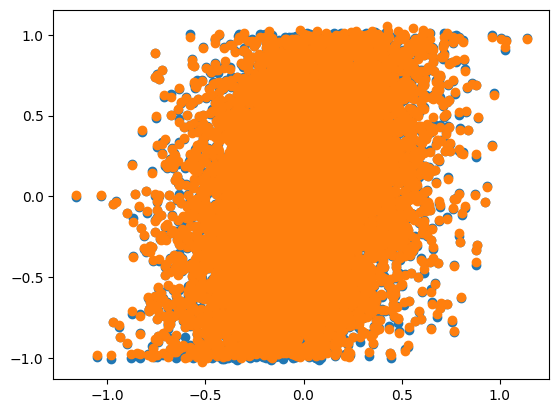

In [42]:
plt.plot(x_train @ w, y_train, 'o')
plt.plot(x_train @ w, model2.forward(x_train).detach(), 'o')

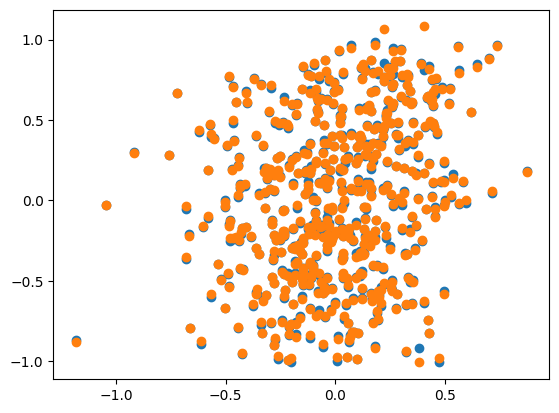

In [43]:
plt.plot(x_test @ w, y_test, 'o')
plt.plot(x_test @ w, model2.forward(x_test).detach(), 'o')

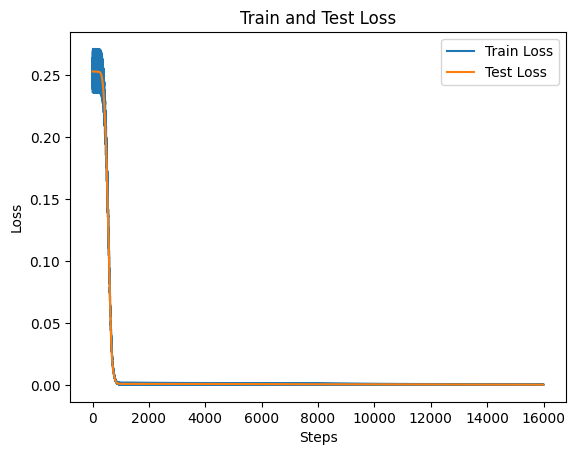

In [44]:
plt.plot(loss_history)
plt.plot(test_loss_history)
plt.title("Train and Test Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])
plt.show()